In [1]:
#!pip install matplotlib
import mlpy

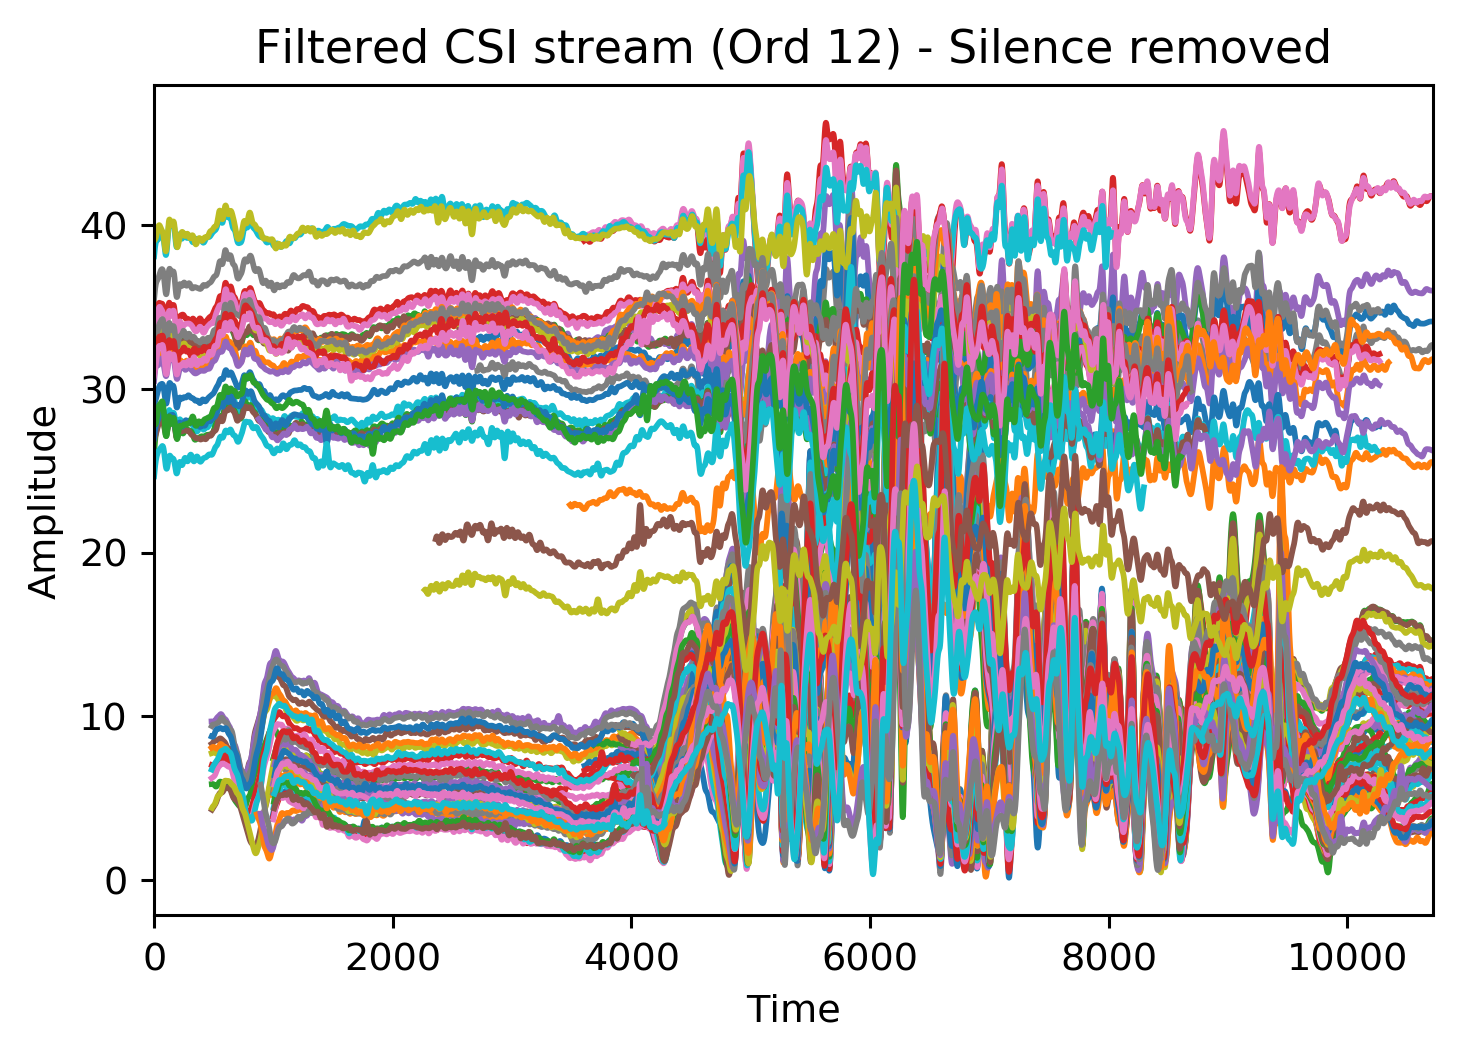

In [4]:

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, medfilt

matlab_file = './Sushant_CSI/1m/backward_converted/log_2.mat'
plt.rcParams['figure.dpi'] = 275

H = [] # this shit will contain the dataset of trimmed data.
original = []

# Load matlab file containing Amplitude domain CSI data
for subcarrier in range(90):

    mat_contents = sio.loadmat(matlab_file)
    antenna = mat_contents['M']
    #subcarrier = 89   # Selected Subcarrier
    fs = 0.05        # Sampling Frequency
    flt_ord = 12     # Filter order number

    # Create list of CSI stream of one subcarrier
    x_axis = []
    y_axis = []
    for i in range(0, len(antenna)):
        x_axis.append(i)
        y_axis.append(antenna[i][subcarrier])

    # plt.plot(y_axis)
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Amplitude')
    # plt.title('Raw CSI stream')

    flt_ord = 12
    b, a = butter(flt_ord, 0.05, 'lowpass', analog=False)
    output = filtfilt(b, a, y_axis)
    original.append(output)

    # plt.plot(output)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Filtered CSI stream (Ord 12)')

    # flt_ord = 5
    # b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
    # output = filtfilt(b, a, y_axis)
    # plt.plot(output)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Filtered CSI stream (Ord 5)')

    # -- SILENCE REMOVAL ---
    import math

    # Separate the CSI data into a sequence of frames
    num_packets = len(output)

    # 50 ms is the number of data(frequency) in each frame.

    data_per_frame = 50
    total_num_frames = math.floor(num_packets/data_per_frame) 

    frames = []
    for frame in range(total_num_frames):
        cur_index = data_per_frame*frame
        seq = output[cur_index : cur_index+data_per_frame]
        frames.append(seq)


    # Calculate energy for each frame
    # Energy each frame = Average of the Squares for each frame
    energy = []
    for frame in frames:
        sq_sum = sum(map(lambda x: x*x, frame))
        e_frame = sq_sum/data_per_frame
        energy.append(e_frame)

    # Apply median filter to energy values and take their log
    filt_energy = medfilt(energy)
    filt_energy = [math.log(e) for e in filt_energy]

    # Select contiguous block of frames s_mid for which energy > mean energy

    # Get indices for which energy > mean energy
    curr_index = 0
    high_energy_indices = []
    mean_energy = sum(filt_energy)/len(filt_energy)
    for energy in filt_energy:
        if energy > mean_energy:
            high_energy_indices.append(curr_index)
        curr_index += 1;

    # Split the high energy indices into contigious subsequences
    curr_index = None
    inside_arr = []
    conti_arr = []
    for index in high_energy_indices:
        if (curr_index is None):
            inside_arr.append(index)
        else:
            if (curr_index == index-1):
                inside_arr.append(index)
            else:
                conti_arr.append(inside_arr)
                inside_arr = []
                inside_arr.append(index)

        curr_index = index

    if inside_arr:
        conti_arr.append(inside_arr)

    # Select the longest contigious subsequence
    s_mid = max(conti_arr, key=len)

    # Get the corresponding CSI data frames h_mid for s_mid
    h_mid = []
    for index in s_mid:
        h_mid.append(frames[index])


    # Calculate the midpoint of the region h_mid which has maximum
    # deviations from the average in h_mid

    high_energy_csi = [item for sublist in h_mid for item in sublist]
    avg_energy = sum(high_energy_csi)/len(high_energy_csi)

    max_dev = 0
    max_dev_index = 0
    for index, energy in enumerate(high_energy_csi):
        deviation = abs(avg_energy - energy)
        if deviation > max_dev:
            max_dev = deviation
            max_dev_index = index

    m = s_mid[0] * data_per_frame + max_dev_index 

    # Set start_point to m−T/2, where T is total duration
    start_point = math.floor(m - (num_packets)/2)
    start_point = max(start_point, 0)

    # Set end_point to m+T/2, where T is total duration
    end_point = math.floor(m + (num_packets)/2)
    end_point = min(end_point, num_packets)

    #Before Silence removal
#     plt.plot(output)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12)')

    # Trimmed output is the CSI stream after silence has been removed.

    trimmed_output = np.full(num_packets, np.nan)
    trimmed_output[start_point:end_point] = output[start_point:end_point]

#     plt.plot(trimmed_output)
#     plt.xlim(left=0, right=num_packets)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12) - Silence removed')

    #print(trimmed_output)
    # ------------------------- IDK if this is correct ---------------------------
    # Finally adding all of the trimmed shit as H ?????

    H.append(trimmed_output)

for trimmed_data in H:
    plt.plot(trimmed_data)
    plt.xlim(left=0, right=num_packets)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Filtered CSI stream (Ord 12) - Silence removed')

# ----------------------------------------- NOW H has all the trimmed data. -------------------

# fs = 500    # The sampling rate
# nfft = 50   # Length of windowing segments
# plt.specgram(output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True)#, xextent=(0,1.627))
# plt.margins(x=0, y=1)

# plt.specgram(trimmed_output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True,)# xextent=(0,1.627))


In [22]:
# for untrimmed in original:
#     plt.plot(untrimmed)
#     plt.xlim(left=0, right=num_packets)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12) - Silence removed') 

# SIGNAL SEPARATION
# Now start Signal separation

dt = 0.1
scales = [6,7,8,9]
print(H[0])
# n = int()
# scales = mlpy.wavelet.autoscales(N=H[0], dt=dt, dj=0.25, wf='morlet', p=1)
mlpy.wavelet.cwt(H[0], dt, [], wf='morlet', p=2)









[       nan        nan        nan ... 8.44206489 8.44274662 8.44334273]


array([], shape=(0, 10717), dtype=complex128)